# Diamond EP Grouping by Resolution Limit - 2.1

In this notebook slightly vary the previous analysis for clearer understanding.

In [1]:
import sys
dirpath = r'C:\Users\César\PycharmProjects\Diamond_ML'
if dirpath not in sys.path:
    sys.path.insert(0, dirpath)
from read_data import data, pd, np, plt, plot_original_data
plt.style.use("ggplot")

## Resolution Limits

It was previously noted that the resolution limits of each group differ from their intended values. We will now see by exactly how much they differ.

DIALS


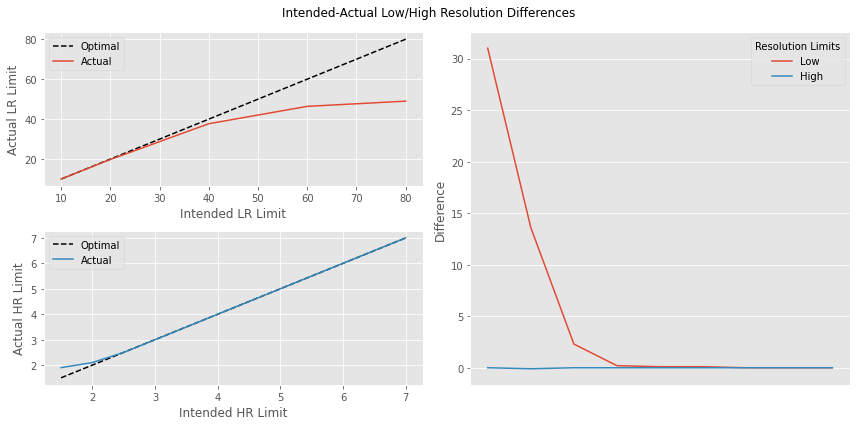

------------------------------------------------------------
3DII


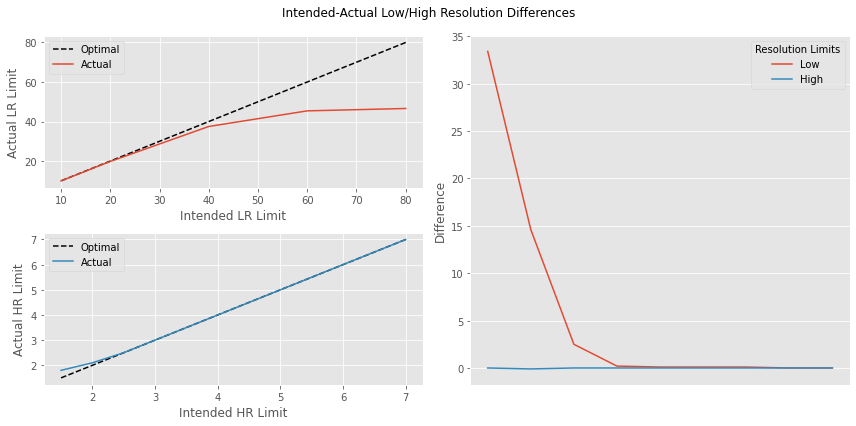

------------------------------------------------------------


In [2]:
from read_data import data, np, pd, plt
from grouping import cluster_spacegroups, GroupedData


lows, highs = ["OG", 80, 60, 40, 20, 18, 16, 14, 12, 10], ["OG", 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7]
for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM"] + r_etc, union=True)
    
    # group data
    groups = GroupedData(x, y)
    groups.group(x["DATASET_NAME"])

    # sort groups
    names = x["DATASET_NAME"].unique().tolist()
    names.sort()
    groups.sort(names, inplace=True)

    # get low/high resolution limits
    res_map = x[["DATASET_NAME", "RESOLUTION_LOW", "RESOLUTION_HIGH"]]
    res_map.set_index("DATASET_NAME", inplace=True)

    # to store success rates in [low_res, high_res] dataframe
    acc_lows, acc_highs = [], []
    
    # for every low/high resolution combination
    for i, group in groups:
        # show general info
        low, high = res_map.loc[i].mean()
        acc_lows.append(low);  acc_highs.append(high)
        
    # store actual resolutions and their difference
    acc_lows = np.array(acc_lows).reshape((10, 10)).mean(axis=1).round(1)
    acc_highs = np.array(acc_highs).reshape((10, 10)).mean(axis=0).round(1)
    diff_lows = [round(lows[i] - acc_lows[i], 2) if isinstance(lows[i], int) else 0 for i in range(len(lows))]
    diff_highs = [round(highs[i] - acc_highs[i], 2) if isinstance(highs[i], int) else 0 for i in range(len(highs))]
    
    # show low/high resolution limits and intended/actual differences
    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 2)
    ax_left = fig.add_subplot(gs[0, 0])
    ax_mid = fig.add_subplot(gs[1, 0])
    ax_right = fig.add_subplot(gs[:, 1])
    
    # low resolution plot
    ax_left.plot(lows[1:], lows[1:], "k--", label="Optimal")
    ax_left.plot(lows[1:], acc_lows[1:], label="Actual")
    ax_left.set_ylabel("Actual LR Limit")
    ax_left.set_xlabel("Intended LR Limit")
    ax_left.legend()
    
    # high resolution plot
    ax_mid.plot(highs[1:], highs[1:], "k--", label="Optimal")
    ax_mid.plot(highs[1:], acc_highs[1:], c="C1", label="Actual")
    ax_mid.set_ylabel("Actual HR Limit")
    ax_mid.set_xlabel("Intended HR Limit")
    ax_mid.legend()
    
    # difference plot
    hoz = np.arange(len(lows) - 1)
    ax_right.plot(hoz, diff_lows[1:], label="Low")
    ax_right.plot(hoz, diff_highs[1:], label="High")
    ax_right.set_ylabel("Difference")
    ax_right.get_xaxis().set_visible(False)
    ax_right.legend(title="Resolution Limits")
    
    # final touches
    fig.suptitle("Intended-Actual Low/High Resolution Differences")
    plt.tight_layout()
    plt.show()

    print("-"*60)

The **low LR limits differ significantly from their intended values**, up to a difference of >30 for the lowest LR. However this difference isn't observed in other limits, since high LR and all HR are in accordance with their intended values.

The effect is similar for both DIALS and XDS.



## Success Rates

Each high/low resolution limit combination is grouped, and a success rate for each combination plotted as a 3d surface.

DIALS


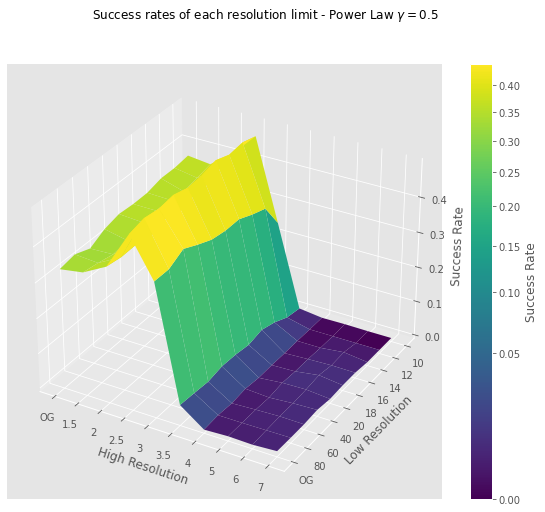

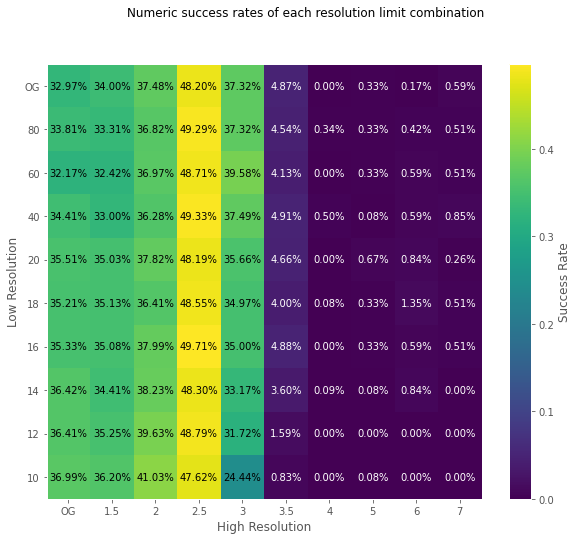

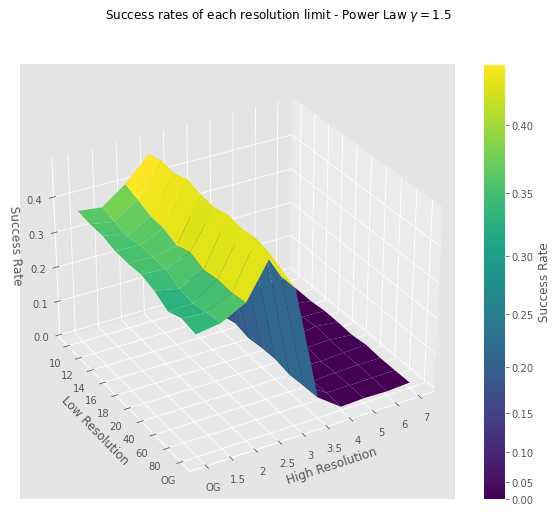

------------------------------------------------------------
3DII


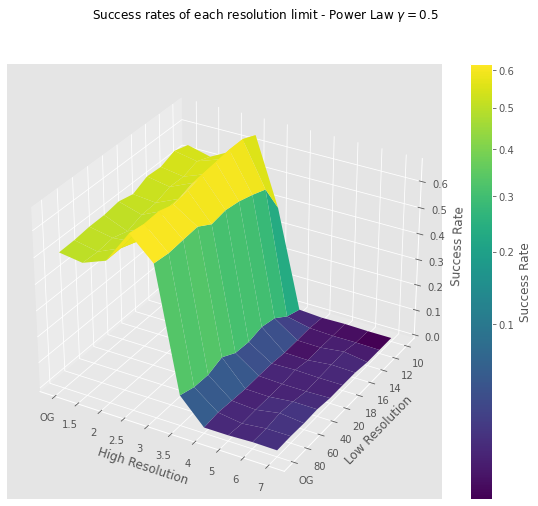

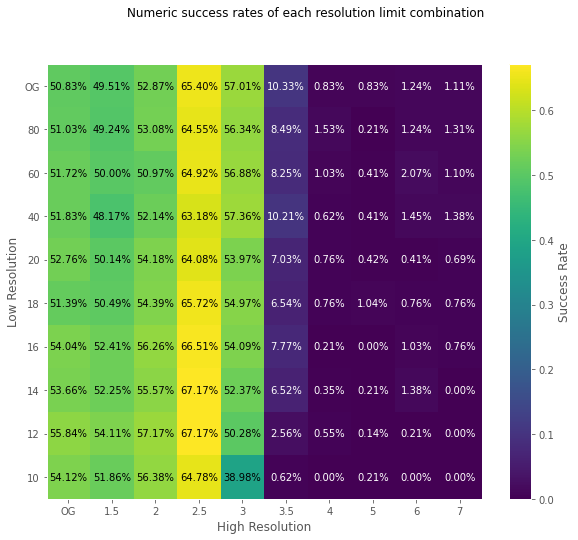

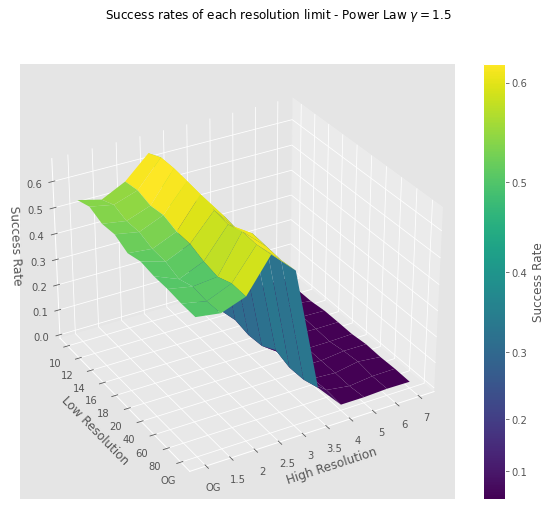

------------------------------------------------------------


In [3]:
%matplotlib inline
from read_data import data, np, pd, plt
from grouping import cluster_spacegroups, GroupedData
from matplotlib.colors import PowerNorm
plt.style.use("ggplot")


lows, highs = ["OG", 80, 60, 40, 20, 18, 16, 14, 12, 10], ["OG", 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7]
for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM"] + r_etc, union=True)

    # encode spacegroup to int based on success rate
    n_clusters = 4 if db_kind == "dials" else 5
    _, spc_grp_map, _ = cluster_spacegroups(union, n_clusters)
    x["SPACEGROUP_CLUSTER"] = x["SPACEGROUP"].map(spc_grp_map)

    # group data
    groups = GroupedData(x, y)
    groups.group(x["DATASET_NAME"])

    # sort groups
    names = x["DATASET_NAME"].unique().tolist()
    names.sort()
    groups.sort(names, inplace=True)

    # get low/high resolution limits
    res_map = x[["DATASET_NAME", "RESOLUTION_LOW", "RESOLUTION_HIGH"]]
    res_map.set_index("DATASET_NAME", inplace=True)

    # to store success rates in array
    success_rates = np.array([group.y.sum() / group.y.size for i, group in groups]).reshape((10, 10))
    
    # reshape success rates into dataframe
    lows, highs = ["OG", 80, 60, 40, 20, 18, 16, 14, 12, 10], ["OG", 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7]
    success_rates = pd.DataFrame(success_rates, index=lows, columns=highs)
    success_rates.index.name = "Low Resolution"
    success_rates.columns.name = "High Resolution"

    
    for gamma in [0.5, 1, 1.5]:
        fig = plt.figure(figsize=(10, 8))
        
        # show annotated heatmap
        if gamma == 1:
            ax = fig.add_subplot()
            img = ax.imshow(success_rates)
            ax.grid(False)
            fig.suptitle(f"Numeric success rates of each resolution limit combination")
            
            for i in range(len(highs)):
                for j in range(len(lows)):
                    num = success_rates.iloc[i, j]
                    c = "k" if num > 0.2 else "w"
                    plt.text(j, i, f"{num:.2%}", ha="center", va="center", color=c)
            
        # show success rates 3d surface
        else:
            ax = fig.add_subplot(projection="3d")
            XX, YY = np.meshgrid(np.arange(len(highs)), np.arange(len(lows)))
            img = ax.plot_surface(XX, YY, success_rates.values, norm=PowerNorm(gamma=gamma), cmap="viridis")
            ax.set_ylabel(success_rates.index.name)
            ax.set_zlabel("Success Rate")
            fig.suptitle(f"Success rates of each resolution limit - Power Law $\gamma={gamma}$")
            
        fig.colorbar(img, label="Success Rate", ax=ax)

        # labels and ticks
        ax.set_xticks(range(len(highs)))
        ax.set_xticklabels(highs)
        ax.set_xlabel(success_rates.columns.name)
        ax.set_yticks(range(len(lows)))
        ax.set_yticklabels(lows)
        ax.set_ylabel(success_rates.index.name)


        # save results
        # plt.savefig(fr"../figures/resolution_grouped_success_rates_{db_kind}_gamma_{gamma}.png")
        if gamma > 1:
            ax.view_init(30, 240)
        plt.show()

    print("-" * 60)


The same general areas as those of previous images can be identified, however the overall behaviour is now clearer.

- **Optimal range would be HR $\simeq$ 2.5**. Here success rates are at their maximum.
- For HR $\lt$ 3 (average success rates), high LR are preferred.
- **Null range for LR $\gt$ 3.5**. Here success rates are $\leq$ 1.5%. In this range prefer low LR.
- In general, **XDS > DIALS**.


LR has little on success rate for most of the HR ranges, however, this is not the case for HR of 3/3.5. In this HR range, LR has a **significant** effect on success rates.

- For **HR = 3**: 0% (0%) to 5% (10%) increase from 10 to 40 LR for DIALS (XDS).
- For **HR = 3.5**:  24% (40%) to 40% (57%) increase from 10 to 60 LR for DIALS (XDS).


## Confidence Threshold Variation

If a client where to use a model to predict whether an EP scan will succeed, they would likely prefer a lower amount of False Positives (FP). Here, a False Negative (FN) is preferrable over a FP. This can be done by changing the probability threshold at which a certain prediction is considered a Success or Not. The default is 0.5. However, if this can be increased to, for example, 0.8, then only samples which are 80% likely to be a success, will be labeled as such.

Common ways to observe this precision-recall trade-off are ROC curves, DET curves, Precision-Recall curves, and others.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, train_test_split
from sklearn.metrics import plot_roc_curve, plot_det_curve, plot_precision_recall_curve, precision_recall_curve
from scipy.stats import randint, expon
from xgboost import XGBClassifier

DIALS
Using seed: 1
Testing model: RandomForestClassifier(class_weight='balanced')
Testing model: KNeighborsClassifier()
Testing model: SVC(class_weight='balanced', probability=True)
Testing model: MLPClassifier(random_state=1)


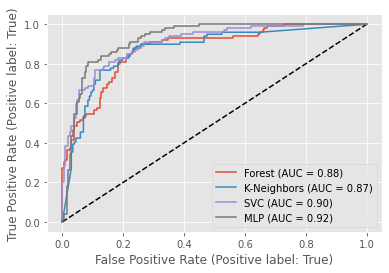

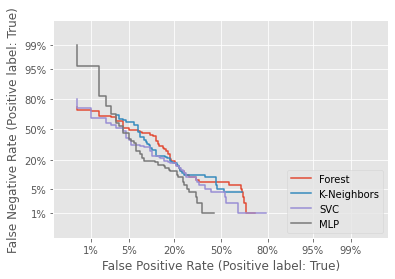

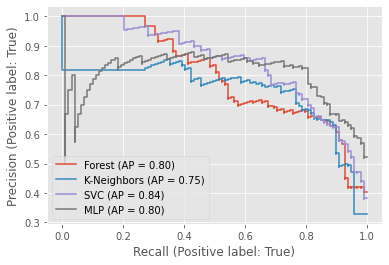

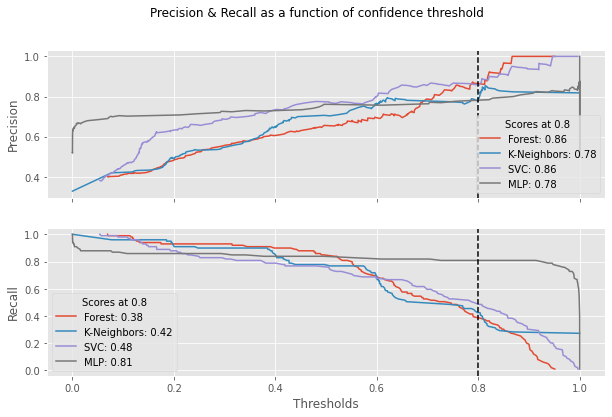

------------------------------------------------------------
3DII
Using seed: 1
Testing model: RandomForestClassifier(class_weight='balanced')
Testing model: KNeighborsClassifier()
Testing model: SVC(class_weight='balanced', probability=True)
Testing model: MLPClassifier(random_state=1)


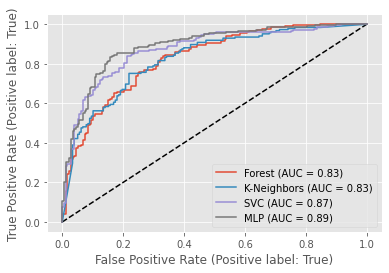

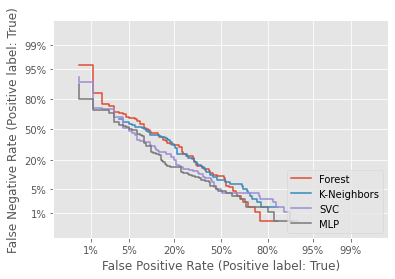

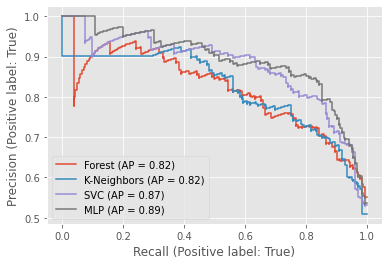

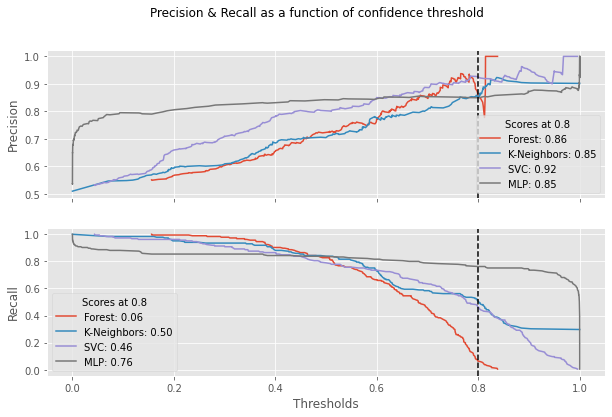

------------------------------------------------------------


In [2]:
class n_layer_dist:
    def __init__(self, low, high, n_layers_range, dist=randint):
        self.dist = dist
        self.low, self.high = low, high
        self.n_layers_dist = dist
        self.n_layers_range = n_layers_range

    def rvs(self, *args, **kwargs):
        size = self.n_layers_dist.rvs(*self.n_layers_range, *args, **kwargs)
        layers = self.dist.rvs(self.low, self.high, size=size, *args, **kwargs)
        return tuple(layers)


for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"] + r_etc, union=True)
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # construct pipelines
    seed = 1
    print(f"Using seed: {seed}")
    scaler = StandardScaler
    forest = Pipeline([("scaler", scaler()), ("clf", RandomForestClassifier(class_weight="balanced"))])
    xgb = Pipeline([("scaler", scaler()), ("clf", XGBClassifier(class_weight="balanced"))])
    kneighbors = Pipeline([("scaler", scaler()), ("clf", KNeighborsClassifier())])
    svc = Pipeline([("scaler", scaler()), ("clf", SVC(class_weight="balanced", probability=True))])
    mlp = Pipeline([("scaler", scaler()), ("clf", MLPClassifier(random_state=seed))])
    
    # create parameter searches
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__n_estimators": randint(100, 10000),  # number of trees in forest
                     "clf__max_features": randint(2, len(x.columns) + 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    kneighbors_params = {"clf__weights": ["uniform", "distance"],
                         "clf__n_neighbors": randint(5, 50)}
    svc_params = {'clf__C': expon(scale=100),
                  'clf__gamma': expon(scale=.1),
                  'clf__kernel': ['rbf', "poly"]}
    mlp_params = {"clf__alpha": 10.0 ** -np.arange(1, 7),
                  "clf__hidden_layer_sizes": n_layer_dist(100, 1000, [1, 5])}

    
    # use randomised search for best possible performance
    n_iter = 50
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)
    kneighbors_search = RandomizedSearchCV(kneighbors, kneighbors_params, n_iter=2, scoring="f1", n_jobs=-1, cv=5, random_state=seed)
    svc_search = RandomizedSearchCV(svc, svc_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)
    mlp_search = RandomizedSearchCV(mlp, mlp_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)
    
    # separate into train/test datasets
    X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=seed)
    
    # prepare figures
    figsize = (8, 6)
    fig_roc, ax_roc = plt.subplots(figsize=figsize)
    ax_roc.plot([0, 1], [0, 1], "k--")
    fig_det, ax_det = plt.subplots(figsize=figsize)
    fig_pr, ax_pr = plt.subplots(figsize=figsize)
    fig_pr_thresh, (ax_prec, ax_rec) = plt.subplots(2, 1, sharex=True, figsize=(10,6))
    
    # iterate over every classifier
    searches = [forest_search, kneighbors_search, svc_search, mlp_search]
    names = ["Forest", "K-Neighbors", "SVC", "MLP"]
    for model, name in zip(searches, names):
        print(f"Testing model: {model.estimator['clf']}")
        # fit models to training datasets
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
    
        # plot ROC/DET/PR curve
        plot_roc_curve(model, X_test, y_test, ax=ax_roc, name=name)
        plot_det_curve(model, X_test, y_test, ax=ax_det, name=name)
        plot_precision_recall_curve(model, X_test, y_test, ax=ax_pr, name=name)
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        
        # find index of 0.8 threshold
        value = 0.8
        ix = np.abs(thresholds - value).argmin()
        ix_prec, ix_rec = precision[ix], recall[ix]
        
        # plot clear precision & recall as a function of threshold, with custom labels
        ax_prec.plot(thresholds, precision[:-1], label=f"{name}: {ix_prec:.2f}")
        ax_rec.plot(thresholds, recall[:-1], label=f"{name}: {ix_rec:.2f}")
        
    # add vertical line at 80% confidence
    ax_prec.axvline(x=0.8, c="k", ls="--")
    ax_rec.axvline(x=0.8, c="k", ls="--")    
    
    # labels
    ax_prec.set_ylabel("Precision")
    ax_rec.set_ylabel("Recall")
    ax_rec.set_xlabel("Thresholds")
    fig_pr_thresh.suptitle("Precision & Recall as a function of confidence threshold")
    ax_prec.legend(title="Scores at 0.8")
    ax_rec.legend(title="Scores at 0.8")
    
    plt.show()
    print("-"*60)

Now that we have the best model, want to see if removing outliers as seen before has any effect.

In [11]:
from sklearn.metrics import matthews_corrcoef, make_scorer, f1_score
from sklearn.neighbors import LocalOutlierFactor


class n_layer_dist:
    def __init__(self, low, high, n_layers_range, dist=randint):
        self.dist = dist
        self.low, self.high = low, high
        self.n_layers_dist = dist
        self.n_layers_range = n_layers_range

    def rvs(self, *args, **kwargs):
        size = self.n_layers_dist.rvs(*self.n_layers_range, *args, **kwargs)
        layers = self.dist.rvs(self.low, self.high, size=size, *args, **kwargs)
        return tuple(layers)


for db_kind, datum in data.items():
    print(db_kind.upper())
    if db_kind == "3dii": continue
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"] + r_etc, union=True)
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # separate data
    seed = 1
    X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=.2, random_state=seed)

    # create model
    n_iter = 1
    mlp = Pipeline([("scaler", StandardScaler()), ("clf", MLPClassifier(random_state=seed))])
    mlp_params = {"clf__alpha": 10.0 ** -np.arange(1, 7),
                  "clf__hidden_layer_sizes": n_layer_dist(100, 1000, [1, 5])}
    mlp_search = RandomizedSearchCV(mlp, mlp_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)
    mlp_search.fit(X_train, y_train)
    y_pred = mlp_search.predict(X_test)
    
    # get scores
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(x.shape, f1, mcc)
    
    # remove outliers
    detector = LocalOutlierFactor(contamination=0.4)
    liers = detector.fit_predict(x)
    mask = liers == 1
    x_clean, y_clean = x.loc[mask, :], y[mask]
    X_train, X_test, y_train, y_test = train_test_split(x_clean, y_clean, stratify=y_clean, test_size=.2, random_state=seed)
    
    # retrain model
    mlp_search.fit(X_train, y_train)
    y_pred = mlp_search.predict(X_test)
    
    # get scores
    f1_clean = f1_score(y_test, y_pred)
    mcc_clean = matthews_corrcoef(y_test, y_pred)
    print(x_clean.shape, f1_clean, mcc_clean)

DIALS
(1201, 28) 0.8333333333333333 0.7477615163351855
(721, 28) 0.8448275862068966 0.7428099579433087
3DII


Indeed, removing the 40% outliers using LOF does slightly help the f1 score while keeping the MCC fairly around the same. Although the variation is so small that it can be due to statistical variance.